# Mode connectivity analysis of the Models
In this notebook we observe the results of the mode connectivity among models.

In [22]:
%reload_ext autoreload
%autoreload 2

In [23]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, module_path)
from plotting_utility import *

## Example of computation

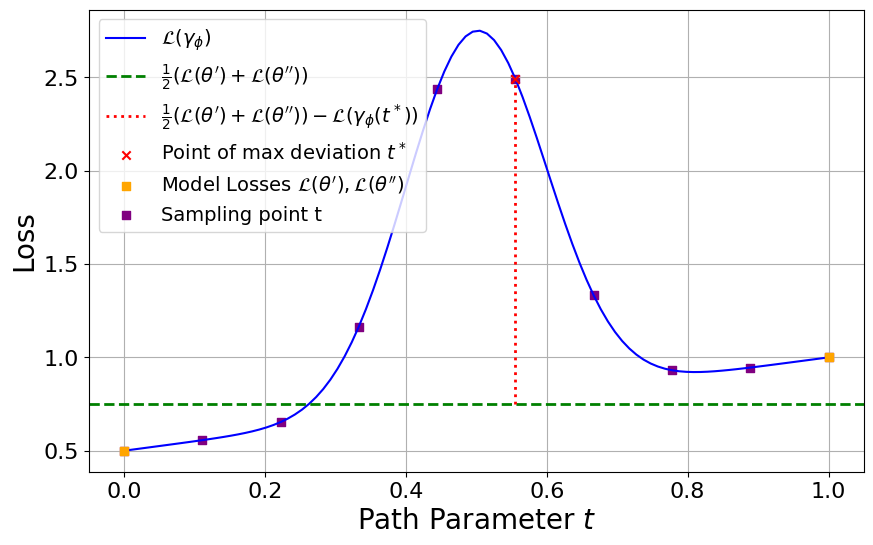

In [24]:
# Adjust losses at the endpoints
loss_theta = 0.5  # Lower loss at θ
loss_theta_prime = 1.0  # Higher loss at θ'

def function(t):
    return (1 - t) * loss_theta + t * loss_theta_prime + 2 * np.exp(-50 * (t - 0.5)**2)

t = np.linspace(0, 1, 100)

# Recompute deviation and mode connectivity metric
samples_x = np.linspace(0, 1 , 10)
samples_y = function(samples_x)
t_star = np.argmax(samples_y)

# Plot the updated loss landscape
plt.figure(figsize=(10, 6))
plt.plot(t, function(t), label=r"$\mathcal{L}(\gamma_\phi)$", color="blue")
plt.axhline(0.5 * (loss_theta + loss_theta_prime), linestyle="--", linewidth=LINE_WIDTH, color="green", 
            label=r"$\frac{1}{2} (\mathcal{L}(\theta') + \mathcal{L}(\theta''))$")
plt.vlines(samples_x[t_star], 0.5 * (loss_theta + loss_theta_prime), samples_y[t_star], colors="red", linewidth=LINE_WIDTH, linestyles="dotted", label=r"$\frac{1}{2}(\mathcal{L}(\theta') + \mathcal{L}(\theta'')) - \mathcal{L}(\gamma_{\phi}(t^*))$")

plt.scatter(samples_x[t_star], samples_y[t_star], color="red", zorder=3, marker="x", label=r"Point of max deviation $t^*$")
plt.scatter([0, 1], [loss_theta, loss_theta_prime], color="orange", zorder=2, marker="s", label=r"Model Losses $\mathcal{L}(\theta'), \mathcal{L}(\theta'')$")
plt.scatter(samples_x, samples_y, color="purple", zorder=1, marker="s", label=r"Sampling point t")

# plt.title("Example of Mode Connectivity computation", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=TICK_SIZE-2)  # Increase major tick label size

plt.xlabel("Path Parameter $t$", fontsize=LABEL_SIZE)
plt.ylabel("Loss", fontsize=LABEL_SIZE)
plt.legend(fontsize=LEGEND_SIZE)
plt.grid(True)
plt.show()

## Metric plots

Load the results in a CSV file:

In [25]:
tags = ["baseline", "JREG_0.1", "LIP_0.00001"]
load_econ_metrics(tags)

Load the results from the CSV: and filter it:

In [26]:
regularizer = ["Baseline", "Jacobian (δ=1e-1)", "Orthogonality (δ=1e-5)"]
df = pd.read_csv("./results/econ/metrics.csv")
selected_df = df[(df['regularizer'].isin(regularizer))]

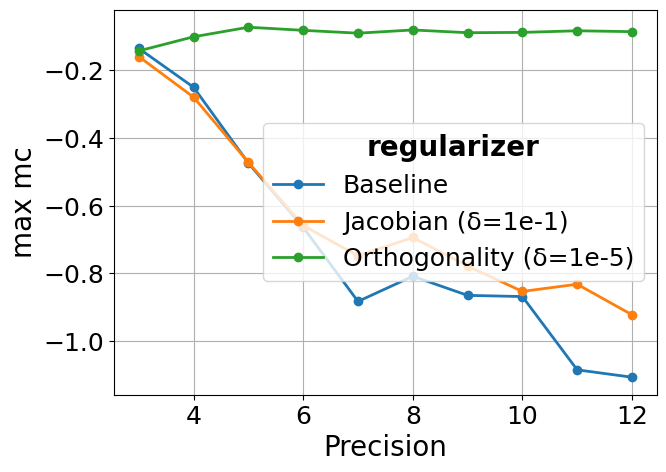

In [27]:
plot_precision_vs_metrics(selected_df, "regularizer", "precision", "max mc", plot_legend=True)

## Ablation studies

Load the ablation studies from the checkpoints:

In [28]:
# store the results
mc = []
for p in precisions:
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            # build the path
            path = os.path.join(DATA_PATH, f"bs{bs}_lr{lr}/ECON_{p}b") 
                        
            for bends, epochs in [(3, 1), (3, 15), (3, 30), (5, 15), (10, 15), (10, 30)]:
                file_name = f"Bezier_bends_{bends}_epochs_{epochs}"
                mc_max = get_metrics_results(path, file_name, "mode_connectivity", "max")
                mc_min = get_metrics_results(path, file_name, "mode_connectivity", "min")
                max_dev = mc_max if abs(mc_max) > abs(mc_min) else mc_min
                mc.append({
                    "batch_size": bs,
                    "learning_rate": lr,
                    "precision": p,
                    "bends | epochs": f"{bends} | {epochs}",
                    "mc": max_dev,
                })
                
                
df_mc = pd.DataFrame(mc)

In [29]:
# plot_precision_vs_metrics(df_mc, "bends | epochs", "precision", "mc", plot_legend=True)